In [4]:
# transformer plus cellular automata: conway game of life
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F
from gameoflife import GameOfLife

batch_size = 8
block_size = 256 # Has to be the square of grid_size to read the full grid
max_iter = 2000
epochs = 10
eval_interval = 500
learning_rate = 8e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embed = 64
n_head = 8
n_layer = 8
dropout = 0.2
text = []

# create dictionaries and then define unique characters for encoding and decoding
tokens = ['0', '1', 's', 'e']

# Example usage with cellular automata
grid_size = 16  # Grid size for the cellular automata
step_count = 10  # Number of steps to evolve the cellular automata

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi['s']] + [stoi[c] for c in s] + [stoi['e']]
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])  # Skipping the first and last items ('s' and 'e')

def generate_random_input_string(size):
    """Generate a random grid as a string for a given grid size."""
    return ''.join(np.random.choice(tokens[:2], size*size))

def generate_game_of_life_sequence(batch_size, grid_size, step_count):
    """Generate a batch of Game of Life initial states and final states."""
    initial_states = [generate_random_input_string(grid_size) for _ in range(batch_size)]
    final_states = []
    for state in initial_states:
        # Directly use state without 's' and 'e' tokens for simulation
        game = GameOfLife(input_string=state, generations=step_count)
        final_state = game.run_simulation()  # Assuming this returns the final state string
        # Only add 's' and 'e' tokens for neural network processing, not for GameOfLife simulation
        final_state_with_tokens = 's' + final_state + 'e'
        final_states.append(final_state_with_tokens)
    # Add 's' and 'e' tokens to initial states after simulation to maintain consistency
    initial_states_with_tokens = ['s' + state + 'e' for state in initial_states]
    return initial_states_with_tokens, final_states

# Define an appropriate size for your validation batch
val_batch_size = 20  

# load data
def get_batch(batch_size, grid_size, step_count, block_size):
    initial_states, final_states = generate_game_of_life_sequence(batch_size, grid_size, step_count)
    X = torch.tensor([enc(s)[:block_size] for s in initial_states], dtype=torch.long)
    Y = torch.tensor([enc(s)[:block_size] for s in final_states], dtype=torch.long)
    return X.to(device), Y.to(device)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.ReLU(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x)) # add x for residual connections
        x = x + self.ffwd(self.ln1(x))
        return x

# bigram language model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1)  # Flatten targets to [batch_size * block_size]
            loss = F.cross_entropy(logits, targets)
            # loss = F.mse_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())

            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx, idx_next), dim = 1)
        return idx
    
model = LanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
loss = None  # Initialize loss variable outside the loop

for epoch in range(epochs):
    for iter in range(max_iter // epochs):  # Distribute iterations across epochs
        model.train()
        xb, yb = get_batch(batch_size, grid_size, step_count, block_size)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if iter % eval_interval == 0 and loss is not None:  # Validation logic
            model.eval()
            with torch.no_grad():
                xv, yv = get_batch(val_batch_size, grid_size, step_count, block_size)
                val_logits, val_loss = model(xv, yv)
                print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
            model.train()

    scheduler.step(val_loss)  # Update the learning rate at the end of each epoch

# Save:
torch.save(model, 'cat_cgol_model.pth')


Epoch 0, Iteration 0: Training Loss = 1.3823407888412476, Validation Loss = 1.1195260286331177
Epoch 1, Iteration 0: Training Loss = 0.6975972652435303, Validation Loss = 0.6928092837333679
Epoch 2, Iteration 0: Training Loss = 0.6899998188018799, Validation Loss = 0.6889697909355164
Epoch 3, Iteration 0: Training Loss = 0.6908531188964844, Validation Loss = 0.6870499849319458
Epoch 4, Iteration 0: Training Loss = 0.686960756778717, Validation Loss = 0.6876137256622314
Epoch 5, Iteration 0: Training Loss = 0.6863221526145935, Validation Loss = 0.684479832649231
Epoch 6, Iteration 0: Training Loss = 0.686628520488739, Validation Loss = 0.6852380037307739
Epoch 7, Iteration 0: Training Loss = 0.688003659248352, Validation Loss = 0.6866730451583862
Epoch 8, Iteration 0: Training Loss = 0.6874486207962036, Validation Loss = 0.6861209273338318
Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9, Iteration 0: Training Loss = 0.6849383115768433, Validation Loss = 0.685603022

Input is: 0011011001001000111110100010110100111011001010111101001110111110

Generated from CA is: 0110111100100100101011111010000000111100100011101010101000000011


Generated from T is: 100000001110000111111111100001010010000111110111010111111010010



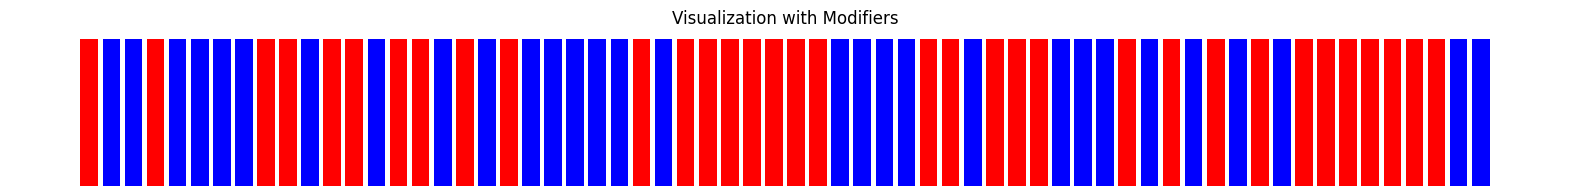

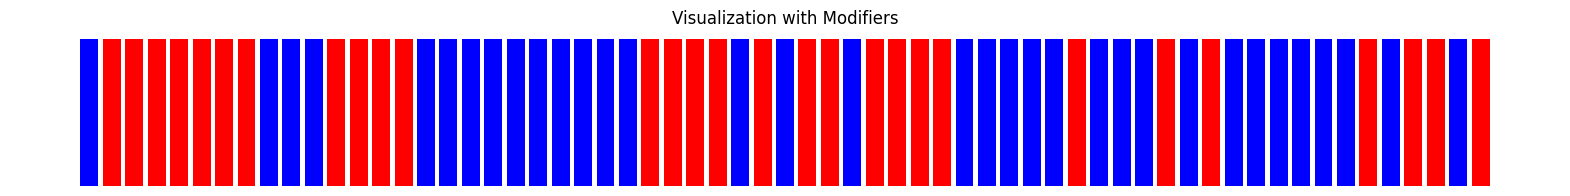

In [5]:
import numpy as np
import matplotlib.pyplot as plt

model = torch.load('cat_cgol_model.pth')
model.eval()
input_length = 8
input_sequence = ''.join(np.random.choice(tokens[:2], input_length*input_length))
print(f"Input is: {input_sequence}")
context = torch.tensor(enc(input_sequence), dtype=torch.long, device=device).unsqueeze(0)
output = model.generate(context, max_new_tokens=len(input_sequence))
generated_text_t = dec(output[0].tolist())
game = GameOfLife(input_sequence, generations=10)

if generated_text_t.startswith('s'):
    generated_text_t = generated_text_t[1:]

generated_text_ca = game.run_simulation()
_, model_generated_sequence = generated_text_t.split('e', 1)

def visualize_grid_with_modifiers(grid):
    """Visualise the grid."""
    base_colors = {'0': 'red', '1': 'blue', ' ': 'grey'}
    colors = []
    for row in grid:
        row_colors = [base_colors[base] for base in row]
        colors.extend(row_colors)

    plt.figure(figsize=(20, 2))
    plt.bar(range(len(colors)), np.ones(len(colors)), color=colors)
    plt.axis('off')
    plt.title('Visualization with Modifiers')
    plt.show()

print(f"\nGenerated from CA is: {generated_text_ca}\n")
print(f"\nGenerated from T is: {model_generated_sequence}\n")
visualize_grid_with_modifiers(generated_text_ca)
visualize_grid_with_modifiers(model_generated_sequence)  # Use the fixed, split decoded output